## Graph Analysis for the Automotive Dataset

In [1]:
import os
import glob

import pandas as pd

import networkx as nx

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches
import matplotlib.lines as mlines

from adjustText import adjust_text

import community as community_louvain

### Preprocessing the Final Results in a Graph Format

In [2]:

def find_match(value, oem_list):
    '''
        This function takes as input a value which represents a company name and the list of OEMs
        from above. If the company name (value) is in the terms to remove or is NOT in the substrings 
        list, then the function returns False. Otherwise, it returns the OEM from the oem_list
    '''

    #manually identified labels which need to be removed from the
    terms_to_remove = ['Alpine Immune Sciences','Alpine Electronics','Army 1st Multi-Domain Task Force','Atlanta first Smart Neighborhood','Morgan Chase & Co','Morgan Dempsey Capital Management','Morgan Engineering Company','Morgan Stanley','Morgan Engineering Company','ParkMirae Asset Daewoo Securities Co','Philippine Air Force','Bulgarian Air Force','Egyptian Air Force','Royal Air Force','Fordand GM','JP MORGAN','Kinder Morgan','Kotak Mahindra Bank','Kotak Mahindra Prime','Lincoln Aviator','Lincoln Nautilus','Royal Bahraini Air Force','Royal Brunei Air Force','Royal Canadian Air Force','Royal Netherlands Air Force','Royal Norwegian Air Force','Royal Saudi Air Force','Ryan J BrinkmanJP Morgan Chase & Co','Smart Cities','Smart Cities Dive - UPS','Smart Energy','Smart Equipment Technology','Smart M','Smart Meter','Smart Mobility','Smart Neighborhood','Smart Neighborhoods','Smart Outlets','Smart nal Stores ',"Smart' Munitions",'South African Air Force','The Department of the Air Force','The French Air and Space Force','The Lincoln Fire Department','US Marine s Air - Ground Task Force','the Air Force','Spanish Land Force']

    
    for term in terms_to_remove:
        if term.lower() in value.lower():
            return False #company should not stay in the graph
    
    for oem in oem_list:
        if oem in value:
            return oem.capitalize()  # Convert the matched substring back to the original case for the output
    
    return False #company should not stay in the graph if it is not an OEM

In [3]:
#recreating again the list of car manufacturers
list_car_manufacturers = [
    'Volkswagen', 'VW', 'VW Group', 'Audi', 'Skoda', 'Seat', 'Cupra', 'KTM', 'Puch', 
    'Nova', 'Nova Bus', 'BRP', 'Campagna', 'Lion Electric', 'BYD', 'Geely', 'Great Wall', 'NIO', 
    'Xpeng', 'SAIC', 'Changan', 'FAW', 'Hongqi', 'Trumpchi', 'GAC', 'Chery', 'Li Auto', 'Rimac', 
    'Tatra', 'Zenvo', 'Electric Raceabout', 'Aixam', 'Alpine', 'DS', 'Citroen', 'Citroën', 'Bugatti', 
    'Peugeot', 'PSA', 'Renault', 'Renault Trucks', 'Alpina', 'BMW', 'Daimler', 'Mercedes', 
    'Mercedes-Benz', 'Opel', 'RUF', 'Porsche', 'Smart', 'Maybach', 'Ashok Leyland', 'Bajaj', 
    'Eicher', 'Hero MotoCorp', 'Mahindra', 'Maruti Suzuki', 'SML Isuzu', 'Tata', 'Tata Motors', 
    'TVS', 'Atul Auto', 'Hindustan', 'ICML', 'Omega Seiki Mobility', 'KAL', 'Esemka', 'Pindad', 
    'Abarth', 'Alfa Romeo', 'Ferrari', 'Fiat', 'Stellantis', 'Lancia', 'Lamborghini', 'Maserati', 
    'Pagani', 'Piaggio', 'Acura', 'Daihatsu', 'Honda', 'Infiniti', 'Isuzu', 'Lexus', 'Mazda', 
    'Mitsubishi', 'Mitsubishi Motors', 'Nissan', 'Subaru', 'Suzuki', 'Toyota', 'Spyker', 'Solaris', 
    'Arrinera', 'Dacia', 'Aurus', 'GAZ', 'Daewoo', 'Hyundai', 'KIA', 'Koenigsegg', 'Polestar', 
    'Volvo', 'Volvo Cars', 'Saab', 'Otokar', 'Aston Martin', 'Bentley', 'Jaguar', 'Lagonda', 
    'Land Rover', 'Range Rover', 'Lotus', 'MINI', 'Morgan', 'Rolls-Royce', 'Rolls Royce', 'McLaren', 
    'TVR', 'Vauxhall', 'Ford', 'GM', 'Chevrolet', 'Cadillac', 'Dodge', 'Jeep', 'Buick', 'GMC', 
    'Chrysler', 'Lincoln', 'Hennessey', 'Shelby', 'SRT', 'Tesla', 'Rivian', 'Lucid Motors', 
    'Fisker', 'Faraday', 'Nikola Motor', 'Canoo', 'BrightDrop', 'Polaris', 'Aptera'
]

#adding manually the countries that these manufacturers represent
companies_with_countries = { 'A123 Systems': 'China', 'Nova':'USA', 'Altair Nanotechnologies': 'USA', 'American Battery Factory': 'USA', 'American Battery Solutions': 'USA', 
                            'Amphenol': 'USA', 'Auto Motive Power': 'USA', 'Clarios': 'USA', 'Cuberg': 'USA', 'Cymbet': 'USA', 'Enersys': 'USA', 'Ford Motor': 'USA', 'HYLIION': 'USA', 
                            'LG Chem': 'South Korea', 'Lockheed Martin': 'USA', 'Morgan Advanced Materials': 'UK', 'Nanoramic Laboratories': 'USA', 'Nuvation Energy': 'USA', 
                            'Our Next Energy': 'USA', 'SGL Carbon': 'Germany', 'Simpliphi Power': 'USA', 'Soelect': 'USA', 'Trojan Battery': 'USA', 'Bmw': 'Germany', 
                            'Mitsubishi': 'Japan', 'Nio': 'China', 'Nissan': 'Japan', 'Renault': 'France', 'Suzuki': 'Japan', 'Tesla': 'USA', 'Toyota': 'Japan', 
                            'Volkswagen': 'Germany', 'Vw': 'Germany', 'Mercedes': 'Germany', 'Mclaren': 'UK', 'Hyundai': 'South Korea', 'Byd': 'China', 'Changan': 'China', 
                            'Daimler': 'Germany', 'Fisker': 'USA', 'Ford': 'USA', 'Honda': 'Japan', 'Gm': 'USA', 'Stellantis': 'Netherlands', 'Volvo': 'Sweden', 'Lucid motors': 'USA', 
                            'Rivian': 'USA', 'Polaris': 'USA', 'Mini': 'UK', 'Li auto': 'China', 'Lincoln': 'USA', 'Kia': 'South Korea', 'Porsche': 'Germany', 'Tata': 'India', 
                            'Vauxhall': 'UK', 'Audi': 'Germany', 'Cadillac': 'USA', 'Chrysler': 'USA', 'Jaguar': 'UK', 'Rimac': 'Croatia', 'Psa': 'France', 'Opel': 'Germany', 
                            'Peugeot': 'France', 'Saab': 'Sweden', 'Smart': 'Germany', 'Xpeng': 'China', 'Skoda': 'Czech Republic', 'Subaru': 'Japan', 'Maserati': 'Italy', 'Mazda': 
                            'Japan', 'Citroen': 'France', 'Canoo': 'USA', 'Faw': 'China', 'Bentley': 'UK', 'Mahindra': 'India', 'Kal': 'India', 'Infiniti': 'Japan', 'Jeep': 'USA', 
                            'Hongqi': 'China', 'Geely': 'China', 'Nikola motor': 'USA', 'Polestar': 'Sweden', 'Pagani': 'Italy', 'Otokar': 'Turkey', 'Lotus': 'UK', 
                            'Lion electric': 'Canada', 'Lexus': 'Japan', 'Land rover': 'UK', 'Maruti suzuki': 'India', 'Seat': 'Spain', 'Shelby': 'USA', 'Srt': 'USA', 
                            'Solaris': 'Poland', 'Lancia': 'Italy', 'Lamborghini': 'Italy', 'Chery': 'China', 'Chevrolet': 'USA', 'Daihatsu': 'Japan', 'Dacia': 'Romania', 
                            'Cupra': 'Spain', 'Citroën': 'France', 'Aston martin': 'UK', 'Ashok leyland': 'India', 'Aptera': 'USA', 'Alpine': 'France', 'Alfa romeo': 'Italy', 
                            'Abarth': 'Italy', 'Buick': 'USA', 'Bugatti': 'France', 'Brp': 'Canada', 'Brightdrop': 'USA', 'Isuzu': 'Japan', 'Great wall': 'China', 'Ferrari': 
                            'Italy', 'Faraday': 'USA', 'Ds': 'France', 'Dodge': 'USA', 'Fiat': 'Italy', 'Gaz': 'Russia', 'Gac': 'China', 'Morgan': 'UK', 'Maybach': 'Germany', 
                            'Rolls royce': 'UK', 'Daewoo': 'South Korea', 'Acura': 'Japan', 'Bajaj': 'India', 'Hindustan': 'India', 'Piaggio': 'Italy' }

mapping_countries_continents = {
    'China': 'Asia',
    'USA': 'North America',
    'South Korea': 'Asia',
    'UK': 'Europe',
    'Germany': 'Europe',
    'Japan': 'Asia',
    'France': 'Europe',
    'Netherlands': 'Europe',
    'Sweden': 'Europe',
    'Turkey': 'Europe',  # Turkey is transcontinental, but often associated with Europe
    'India': 'Asia',
    'Canada': 'North America',
    'Italy': 'Europe',
    'Spain': 'Europe',
    'Croatia': 'Europe',
    'Czech Republic': 'Europe',
    'Romania': 'Europe',
    'Russia': 'Russia'
}

#creating a pattern for matching them with the results
list_car_manufacturers = [s.lower() for s in list_car_manufacturers]
pattern = '|'.join(list_car_manufacturers)

#### Main Code for running the preprocessing

In [4]:
#readin in the results from the anlaysis from notebook prompt_chatgpt
folder = 'final_results/'

data = pd.DataFrame()

#as we need to read multiple csv files, because we parse intermediate results
#we need to iterate through them
if os.path.isdir(folder):
    
    # find the CSV file ending with ews.csv in the subfolder to read from them
    csv_files = glob.glob(os.path.join(folder, '*.csv'))

    for file in csv_files:
        data_temp = pd.read_csv(file)

        #append to the empty df
        data = pd.concat([data, data_temp], axis = 0)

In [5]:
#preprocessing the company names to keep only NAATBatt companies and OEMs
data["connection_clean"] = data['connection'].str.lower()
data['connection_clean'] = data['connection_clean'].apply(find_match, oem_list=list_car_manufacturers)

#if company is not an OEM or is in the list of exclusions, we do not consider it
data = data[data['connection_clean'] != False]

data.reset_index(inplace = True)
data.drop('Unnamed: 0', axis = 1, inplace = True)

#### Create Edge List

In [6]:
edge_list = data[['company','connection_clean','result']]

#grouping by company pair and result to remove redundacies
edge_list = edge_list.groupby(['company', 'connection_clean', 'result']).size().reset_index(name='count')
edge_list = edge_list.sort_values(by='company').reset_index(drop=True) #for readability

#if the result from the LLM classification is nothing, we do not parse it
edge_list = edge_list[edge_list['result']!='nothing']

In [7]:
#parsing the data in the format that networkx works with
edge_list_1 = [
    (
        row['company'], #first node from edge
        row['connection_clean'], #second node from edge
        {
            'relationship': row['result'], #relationship classified by the LLM
             'weight': row['count'] #weight represented by how many edges are identical
        }
        
    )
    for _, row in edge_list.iterrows() #iterating through the dataframe
]


##### Pandas Profiling for the Edge List

In [48]:
import pandas as pd
from ydata_profiling import ProfileReport

# Step 4: Generate the profile report
profile = ProfileReport(edge_list, title="Pandas Profiling Report", explorative=True)

# Step 5: Display the report in a Jupyter notebook
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

#### Create Node List from Edge List 

In [8]:
#parsing the data in the format that networkx works with
node_list = [
    (
        row['company'],  #node id
        {
            'label':row['company'], #node label
            'type':'NAATBatt', #node attribute representing if it is a battery producer or OEM
            'country':companies_with_countries[row['company']], #location from previously created list
            'continent': mapping_countries_continents[companies_with_countries[row['company']]]  # continent based on country
            
        },
    )
    for _, row in edge_list.iterrows()#iterating through the dataframe
     ]
node_list_2 = [
     (
        row['connection_clean'], #node id
            {
            'label':row['connection_clean'], #node label
            'type':'OEM',#node attribute representing if it is a battery producer or OEM
            'country':companies_with_countries[row['connection_clean']], #location from previously created list
            'continent': mapping_countries_continents[companies_with_countries[row['connection_clean']]]  # continent based on country
        },
    )
    for _, row in edge_list.iterrows()#iterating through the dataframe
]

#adding together the two lists
node_list = node_list + node_list_2

#### Creating and Saving Graph Using Networkx

In [9]:
G = nx.Graph()
G.add_nodes_from(node_list) 
G.add_edges_from(edge_list_1)

In [10]:
#check if the network is connected
nx.is_connected(G)

True

In [11]:
#parsing the graph in .graphml format for iteroperability with graphdatabases (e.g. Neo4J)
nx.write_graphml(G, "automotive_battery_network.graphml")

### Analyzing the Basic Information of the Graph

In [12]:
print(f"We have a graph of {type(G)}, which means it is undirected")

We have a graph of <class 'networkx.classes.graph.Graph'>, which means it is undirected


In [13]:
print(f"The graph has {len(G.edges())} edges")
print(f"The graph has {len(G.nodes())} nodes")

The graph has 337 edges
The graph has 116 nodes


#### Centrality Measures

In [14]:
#getting the degrees of nodes in a pd.df
degrees = pd.DataFrame(nx.degree(G), columns = ['company', 'degree'])

#printing the head and tail of df
degrees.sort_values(by = 'degree')

,company,degree
115,Saab,1
1,Altair Nanotechnologies,1
14,Morgan Advanced Materials,1
105,Gaz,1
83,Daihatsu,1
...,...,...
6,Clarios,22
13,Lockheed Martin,23
9,Enersys,26
12,LG Chem,82


In [15]:

#printing min and max degrees
max_degre = degrees.loc[degrees['degree'].idxmax()]
min_degre = degrees.loc[degrees['degree'].idxmin()]

print(f"Node with maximum closeness centrality:\n{max_degre}")
print("\n")
print(f"Node with minimum closeness centrality:\n{min_degre}")

Node with maximum closeness centrality:
company    Ford Motor
degree             85
Name: 10, dtype: object


Node with minimum closeness centrality:
company    Altair Nanotechnologies
degree                           1
Name: 1, dtype: object


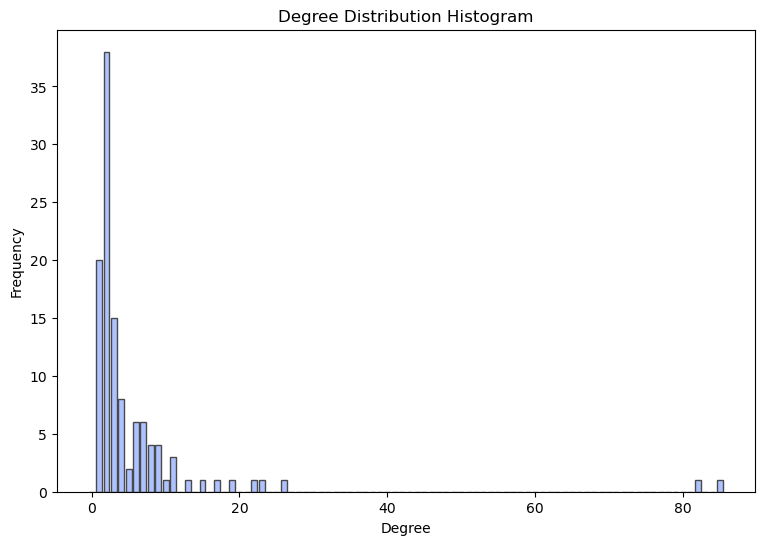

In [16]:
# compute the degree histogram
degree_hist = nx.degree_histogram(G)
plt.figure(figsize=(9, 6))
# Plotting the histogram
plt.bar(range(len(degree_hist)), degree_hist, color='#aec2ff', edgecolor='#494949')

# adding labels and title
plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.title('Degree Distribution Histogram')

# display the plot
plt.show()

In [17]:
df_closeness = pd.DataFrame(list(nx.closeness_centrality(G).items()), columns=['Node', 'Closeness Centrality'])
df_closeness.sort_values(by = 'Closeness Centrality', ascending = False)

,Node,Closeness Centrality
10,Ford Motor,0.741935
12,LG Chem,0.714286
26,Tesla,0.520362
21,Bmw,0.502183
39,Gm,0.502183
...,...,...
20,Trojan Battery,0.343284
19,Soelect,0.335277
1,Altair Nanotechnologies,0.329513
14,Morgan Advanced Materials,0.318560


In [18]:
# Select the node with the maximum closeness centrality
max_closeness = df_closeness.loc[df_closeness['Closeness Centrality'].idxmax()]

# Select the node with the minimum closeness centrality
min_closeness = df_closeness.loc[df_closeness['Closeness Centrality'].idxmin()]

print("Node with maximum closeness centrality:")
print(max_closeness)

print("\nNode with minimum closeness centrality:")
print(min_closeness)

Node with maximum closeness centrality:
Node                    Ford Motor
Closeness Centrality      0.741935
Name: 10, dtype: object

Node with minimum closeness centrality:
Node                        Saab
Closeness Centrality    0.289673
Name: 115, dtype: object


In [19]:
# Compute the eigenvector centrality with weights
eigenvector_centrality = nx.eigenvector_centrality_numpy(G, weight='weight')

# Create a pandas DataFrame from the eigenvector centrality dictionary
df_eigenvector = pd.DataFrame(list(eigenvector_centrality.items()), columns=['Node', 'Eigenvector Centrality'])
df_eigenvector.sort_values(by = 'Eigenvector Centrality', ascending = False)


,Node,Eigenvector Centrality
12,LG Chem,0.705901
28,Volkswagen,0.426195
32,Hyundai,0.388308
41,Volvo,0.281038
21,Bmw,0.147611
...,...,...
83,Daihatsu,0.000050
14,Morgan Advanced Materials,0.000023
19,Soelect,0.000011
115,Saab,0.000008


In [20]:
# Select the node with the maximum eigenvector centrality
max_eigenvector = df_eigenvector.loc[df_eigenvector['Eigenvector Centrality'].idxmax()]

# Select the node with the minimum eigenvector centrality
min_eigenvector = df_eigenvector.loc[df_eigenvector['Eigenvector Centrality'].idxmin()]

print("Node with maximum eigenvector centrality:")
print(max_eigenvector)

print("\nNode with minimum eigenvector centrality:")
print(min_eigenvector)

Node with maximum eigenvector centrality:
Node                       LG Chem
Eigenvector Centrality    0.705901
Name: 12, dtype: object

Node with minimum eigenvector centrality:
Node                      Altair Nanotechnologies
Eigenvector Centrality                   0.000002
Name: 1, dtype: object


In [21]:
# Diameter
diameter = nx.diameter(G)
print(f"The diameter of the network graph is {diameter}")

# Transitivity
tg = nx.transitivity(G)
print(f"The Global Transitivity of the network graph is {tg}")

# Average path length
apl = nx.average_shortest_path_length(G)
print(f"The Average Path Length of the network graph is {apl}")

The diameter of the network graph is 5
The Global Transitivity of the network graph is 0
The Average Path Length of the network graph is 2.2655172413793103


#### Connectivity of the Graph

In [22]:
# Vertex connectivity
vc = nx.node_connectivity(G)
print(f"The vertex connectivity for the network is {vc}")

# Vertex connectivity
ec = nx.edge_connectivity(G)
print(f"The edge connectivity for the network is {ec}")

The vertex connectivity for the network is 1
The edge connectivity for the network is 1


#### Number of Louvain Communities

In [23]:
len(nx.community.louvain_communities(G))

4

### Creating Visualisations

In [24]:
# set a seed for reproducible results
import random
random.seed(2209)
import numpy as np
np.random.seed(2209)

#### Starting Point: Initial NX Graph

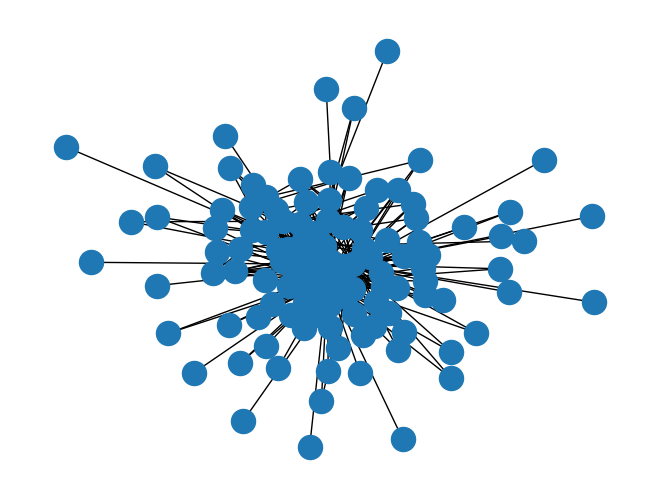

In [25]:
nx.draw(G)

In [26]:
G.edges['A123 Systems', 'Bmw']

{'relationship': 'supplier', 'weight': 3}

In [27]:
pos = nx.spring_layout(G)
type_company = nx.get_node_attributes(G, 'type')
labels = nx.get_node_attributes(G, 'label')

unique_types = list(set(type_company.values()))
colors = plt.cm.Blues(np.linspace(0.3, 0.7, len(unique_types)))
type_colors = {utype: colors[i] for i, utype in enumerate(unique_types)}
node_colors = [type_colors[type_company[node]] if type_company[node] else 'grey' for node in G.nodes]

label_pos = {node: (x, y + 0.028) for node, (x, y) in pos.items()}

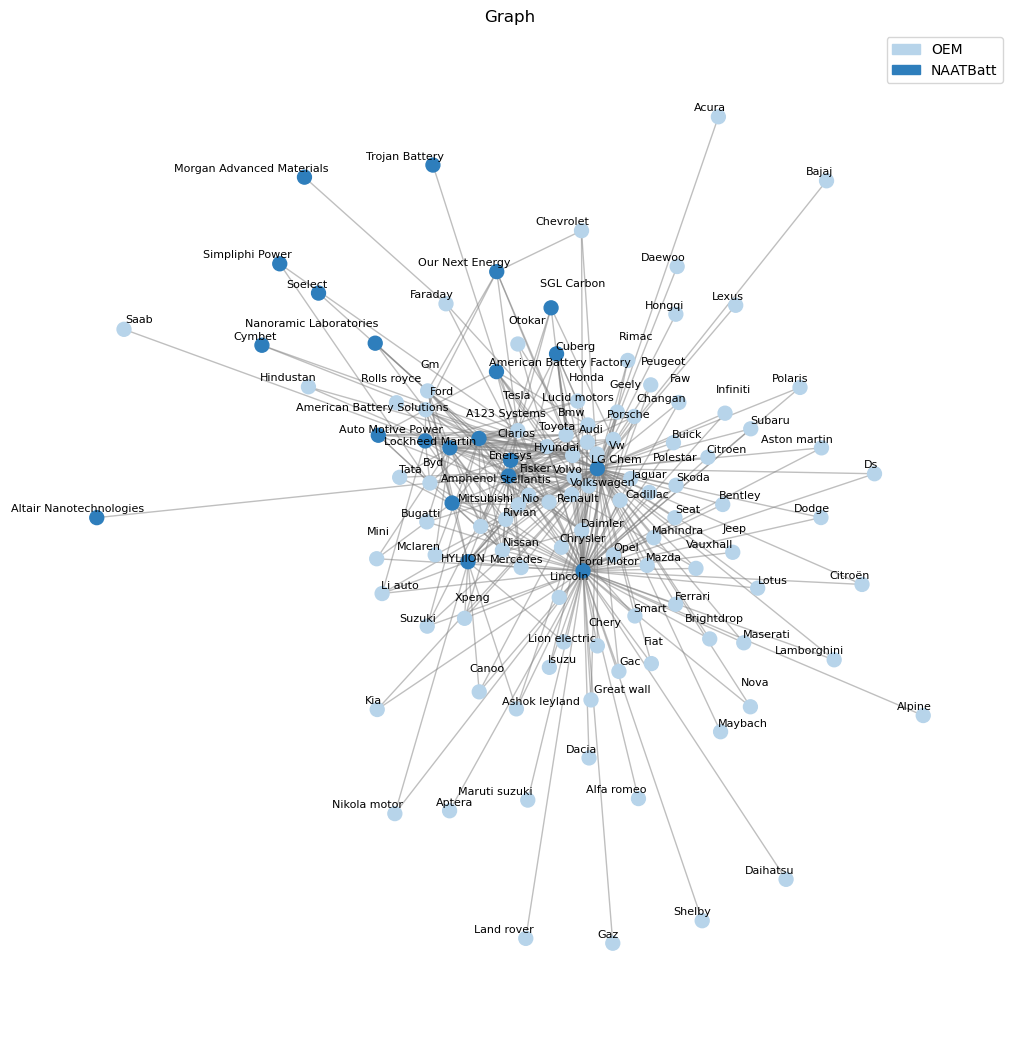

In [28]:

plt.figure(figsize=(10, 10))
# Draw edges and set node_size to 0 to avoid overlap
nx.draw(G, pos, edge_color='grey', alpha=0.5, node_size=0)
# Draw nodes separately
nx.draw_networkx_nodes(G, pos, node_size=100, node_color=node_colors)

# Prepare labels for adjustText
texts = [plt.text(label_pos[node][0], label_pos[node][1], labels[node], fontsize=8, ha='center', va='center') for node in G.nodes if node in labels]

# Use adjustText to minimize overlaps
adjust_text(texts)

legend_handles = [mpatches.Patch(color=color, label=type_label) for type_label, color in type_colors.items()]

# Add the legend
plt.legend(handles=legend_handles, loc='upper right')

plt.title('Graph')
plt.show()

#### Graph per continent

In [53]:
pos = nx.spring_layout(G)
continents = nx.get_node_attributes(G, 'continent')
labels = nx.get_node_attributes(G, 'label')

unique_continents = list(set(continents.values()))
colors = plt.cm.coolwarm(np.linspace(0, 1, len(unique_continents)))
continent_colors = {utype: colors[i] for i, utype in enumerate(unique_continents)}
node_colors = [continent_colors[continents[node]] if continents[node] else 'grey' for node in G.nodes]

label_pos = {node: (x, y + 0.028) for node, (x, y) in pos.items()}

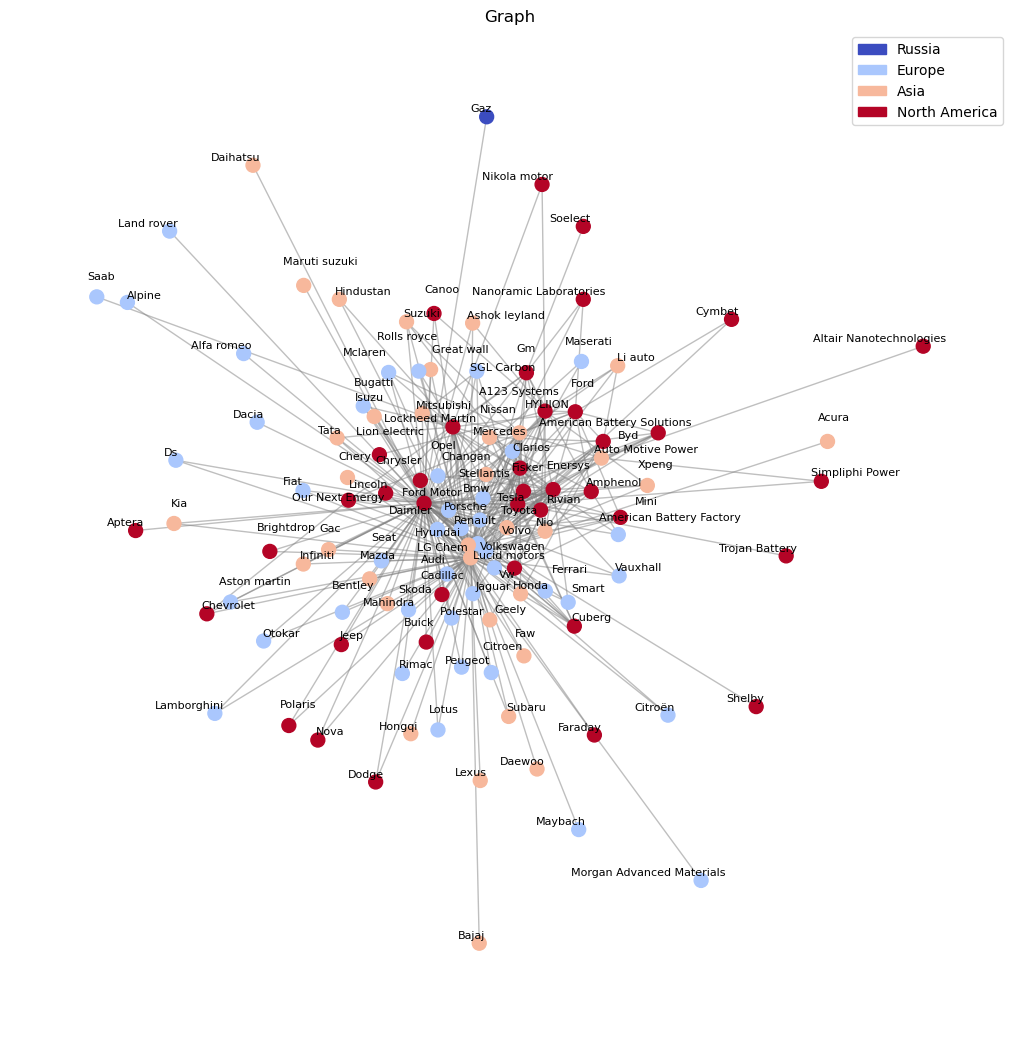

In [56]:
import matplotlib.patches as mpatches

plt.figure(figsize=(10, 10))
# Draw edges and set node_size to 0 to avoid overlap
nx.draw(G, pos, edge_color='grey', alpha=0.5, node_size=0)
# Draw nodes separately
nx.draw_networkx_nodes(G, pos, node_size=100, node_color=node_colors)

# Prepare labels for adjustText
texts = [plt.text(label_pos[node][0], label_pos[node][1], labels[node], fontsize=8, ha='center', va='center') for node in G.nodes if node in labels]

# Use adjustText to minimize overlaps
adjust_text(texts)

legend_handles = [mpatches.Patch(color=color, label=continents) for continents, color in continent_colors.items()]

# Add the legend
plt.legend(handles=legend_handles, loc='upper right')

plt.title('Graph')
plt.savefig('graph_countries.png')

#### Highlighting Closeness Centrality

In [31]:
#adding centrality to the graph object
closeness = nx.closeness_centrality(G)
nx.set_node_attributes(G, closeness, 'centrality')

#obtaining node scales - we will use an exponential scaling to make the differences more agressive
scaling_factor = 1000
exponent = 3

# Generate node sizes based on the attribute
node_sizes = [G.nodes[node]['centrality'] ** exponent * scaling_factor   for node in G.nodes]

In [32]:
#coloring based on OEMs or NAATBatt
pos = nx.spring_layout(G)

type_company = nx.get_node_attributes(G, 'type')
labels = nx.get_node_attributes(G, 'label')

unique_types = list(set(type_company.values()))
colors = plt.cm.Blues(np.linspace(0.3, 0.7, len(unique_types)))
type_colors = {utype: colors[i] for i, utype in enumerate(unique_types)}
node_colors = [type_colors[type_company[node]] if type_company[node] else 'grey' for node in G.nodes]

label_pos = {node: (x, y + 0.028) for node, (x, y) in pos.items()}

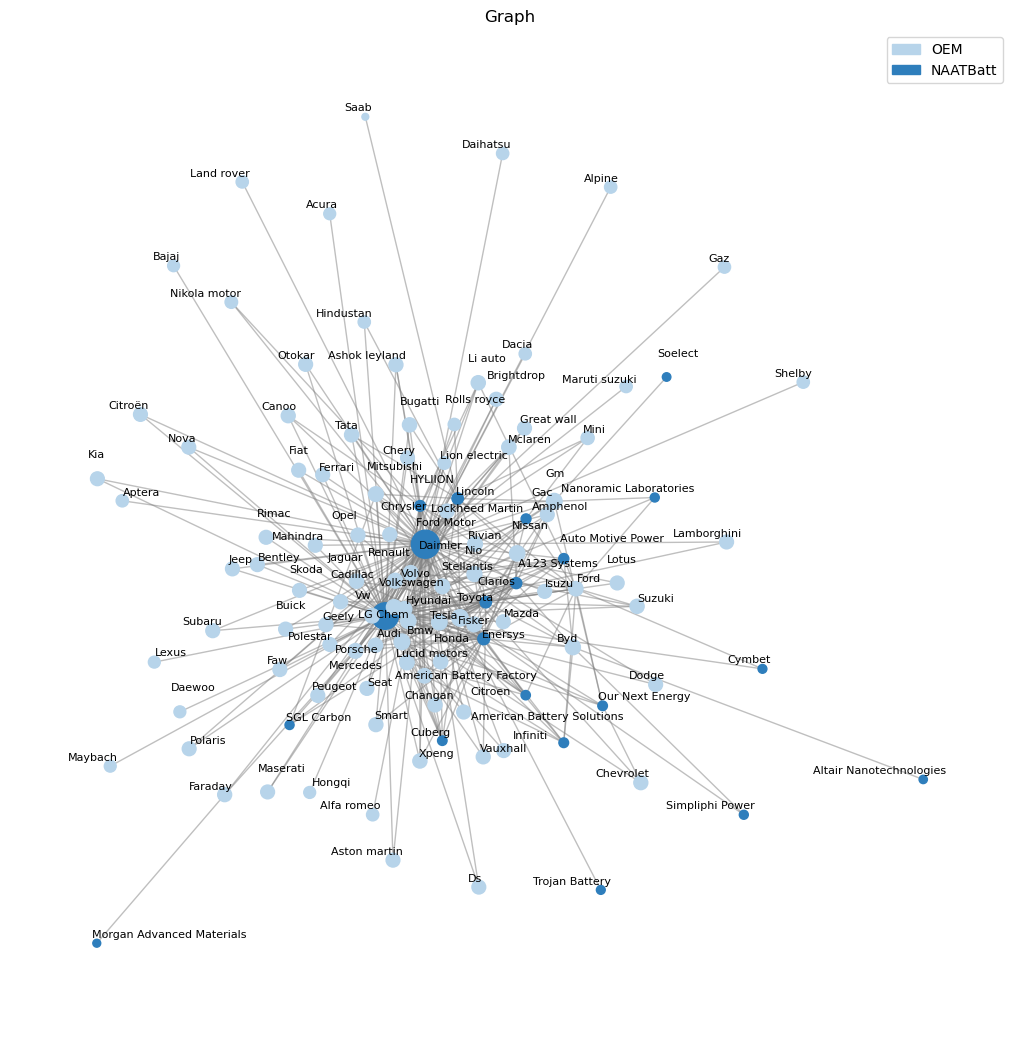

In [33]:
plt.figure(figsize=(10, 10))
# Draw edges and set node_size to 0 to avoid overlap
nx.draw(G, pos, edge_color='grey', alpha=0.5, node_size=0)
# Draw nodes separately
nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color=node_colors)

# Prepare labels for adjustText
texts = [plt.text(label_pos[node][0], label_pos[node][1], labels[node], fontsize=8, ha='center', va='center') for node in G.nodes if node in labels]

# Use adjustText to minimize overlaps
adjust_text(texts)

legend_handles = [mpatches.Patch(color=color, label=type_company) for type_company, color in type_colors.items()]

# Add the legend
plt.legend(handles=legend_handles, loc='upper right')
plt.title('Graph')
plt.show()

#### Coloring the Edges as Well:

In [34]:
def most_informative_plot(G, figsize = 10, scaling_factor = 1000, small = False):
    
    #obtaining node scales - we will use an exponential scaling to make the differences more agressive
    exponent = 3
    
    # Generate node sizes based on the attribute
    node_sizes = [G.nodes[node]['centrality'] ** exponent * scaling_factor   for node in G.nodes]

    #-------------edge coloring------------
    edge_colors = {
        'supplier': 'lightgreen',
        'buyer': 'darkgreen',
        'partnership': '#b40426',
        'merger':'#f7b89c'
    }
    
    
    edge_colors_list = [
        edge_colors.get(G[u][v]['relationship'], 'gray') for u, v in G.edges()
    ]
    if small == True:
        pos = nx.fruchterman_reingold_layout(G)
    else: pos = nx.spring_layout(G)
    #-------------nodes coloring------------

    #coloring based on OEMs or NAATBatt
    
    type_company = nx.get_node_attributes(G, 'type')
    labels = nx.get_node_attributes(G, 'label')
    
    unique_types = list(set(type_company.values()))
    colors = plt.cm.Blues(np.linspace(0.3, 0.7, len(unique_types)))
    type_colors = {utype: colors[i] for i, utype in enumerate(unique_types)}
    node_colors = [type_colors[type_company[node]] if type_company[node] else 'grey' for node in G.nodes]
    
    label_pos = {node: (x, y + 0.03) for node, (x, y) in pos.items()}

    #-------------draw graph------------
    plt.figure(figsize=(figsize, figsize))
    # Draw edges and set node_size to 0 to avoid overlap
    nx.draw(G, pos, edge_color=edge_colors_list, alpha=0.5, node_size=0)
    # Draw nodes separately
    nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color=node_colors)
    
    # Prepare labels for adjustText
    texts = [plt.text(label_pos[node][0], label_pos[node][1], labels[node], fontsize=8, ha='center', va='center') for node in G.nodes if node in labels]
    

    # Use adjustText to minimize overlaps
    adjust_text(texts)
    
    #-------------draw legend------------

    #creating the legend
    relationship_legend = [
        mlines.Line2D([], [], color=color, linewidth=2, label=relationship)
        for relationship, color in edge_colors.items()
    ]
    nodes_legend = [mpatches.Patch(color=color, label=type_company) for type_company, color in type_colors.items()]
    legend_handles = relationship_legend + nodes_legend
    
    # Add the legend
    plt.legend(handles=legend_handles, loc='upper right')
    
    
    plt.title('Graph')

    return plt

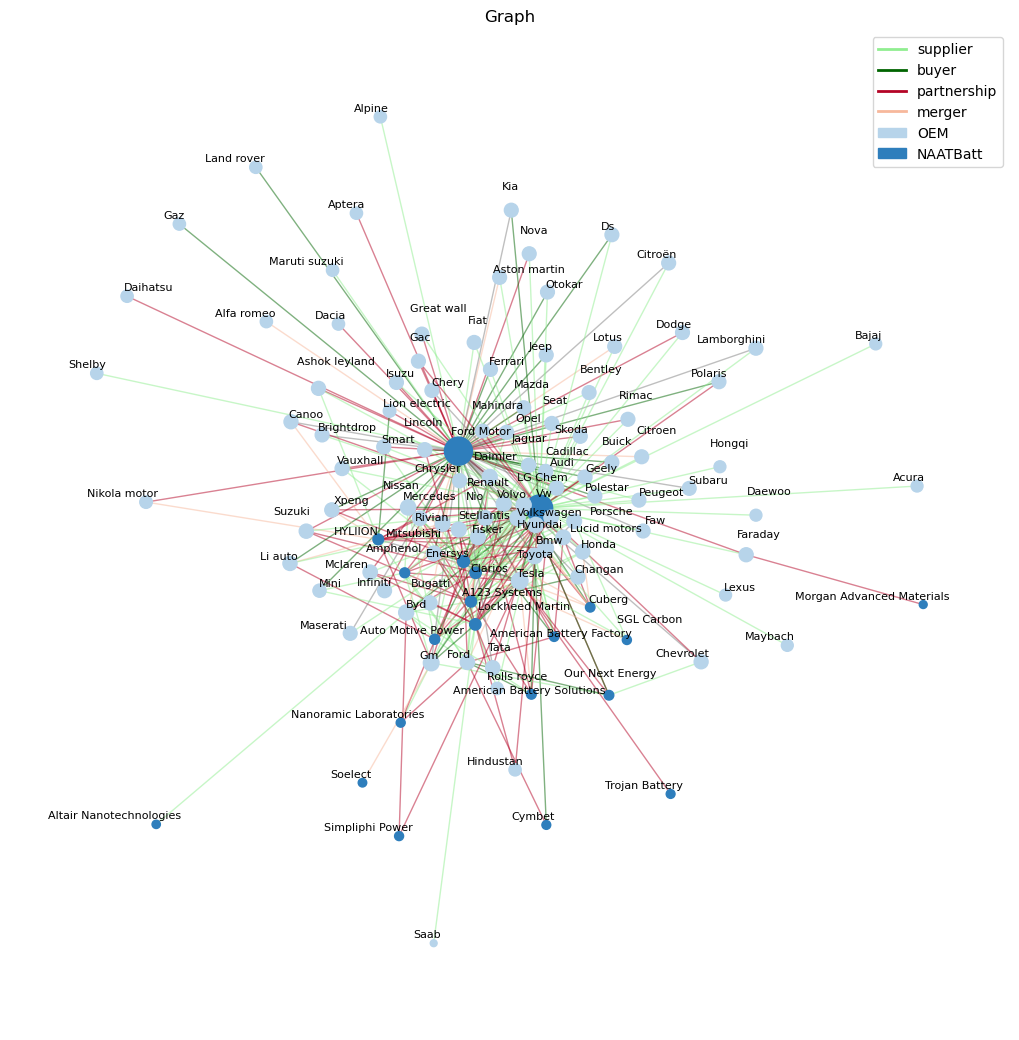

In [35]:
most_informative_plot(G).show()

#### Graph based on the supplier-buyer relationship

In [36]:

#filtering edges for supplier buyer relationships
filtered_edges = [(u, v) for u, v, attrs in G.edges(data=True) if attrs['relationship'] in ['supplier', 'buyer']]


In [37]:
#create subgraph
H = G.edge_subgraph(filtered_edges)


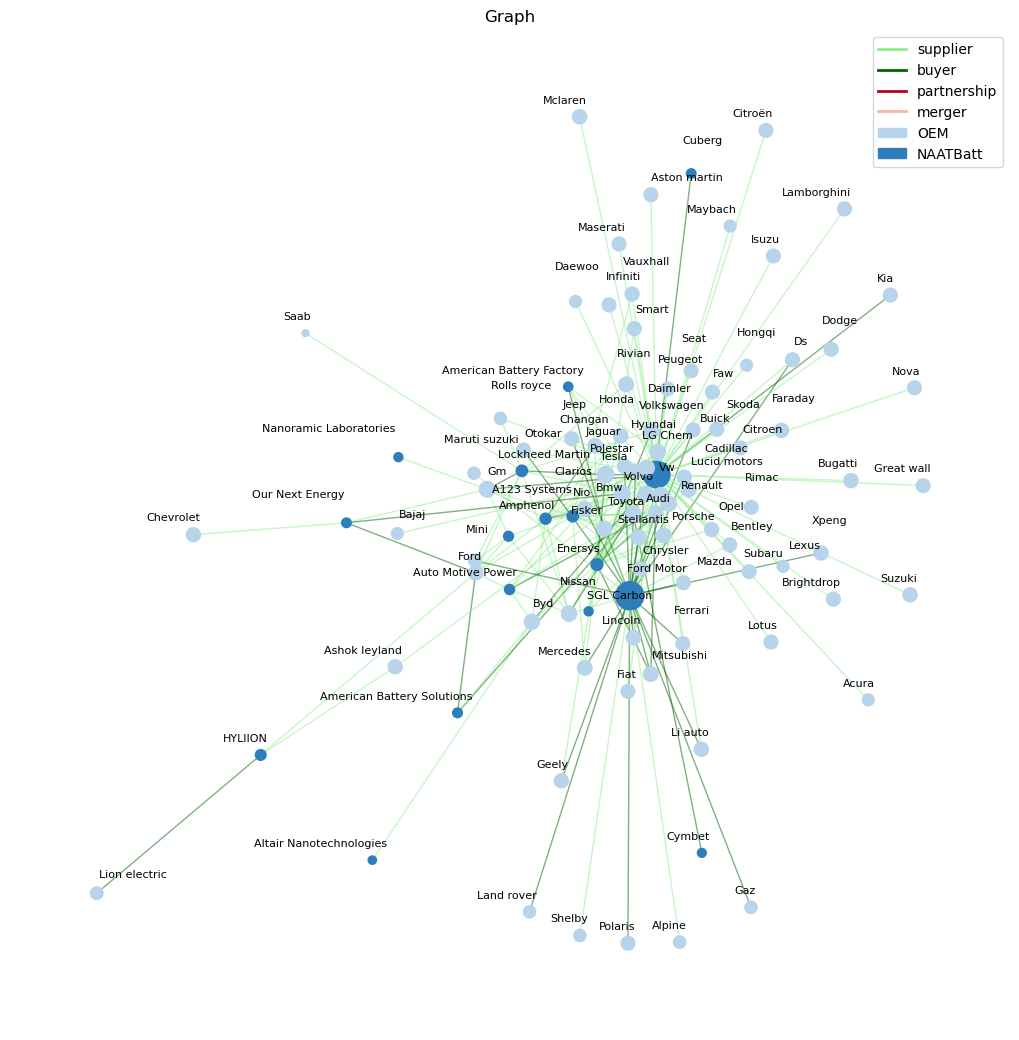

In [38]:
most_informative_plot(H).show()

#### Graph based on mergers

In [39]:

#filtering edges for supplier buyer relationships
filtered_edges = [(u, v) for u, v, attrs in G.edges(data=True) if attrs['relationship'] in ['merger']]


In [40]:
#create subgraph
H = G.edge_subgraph(filtered_edges)


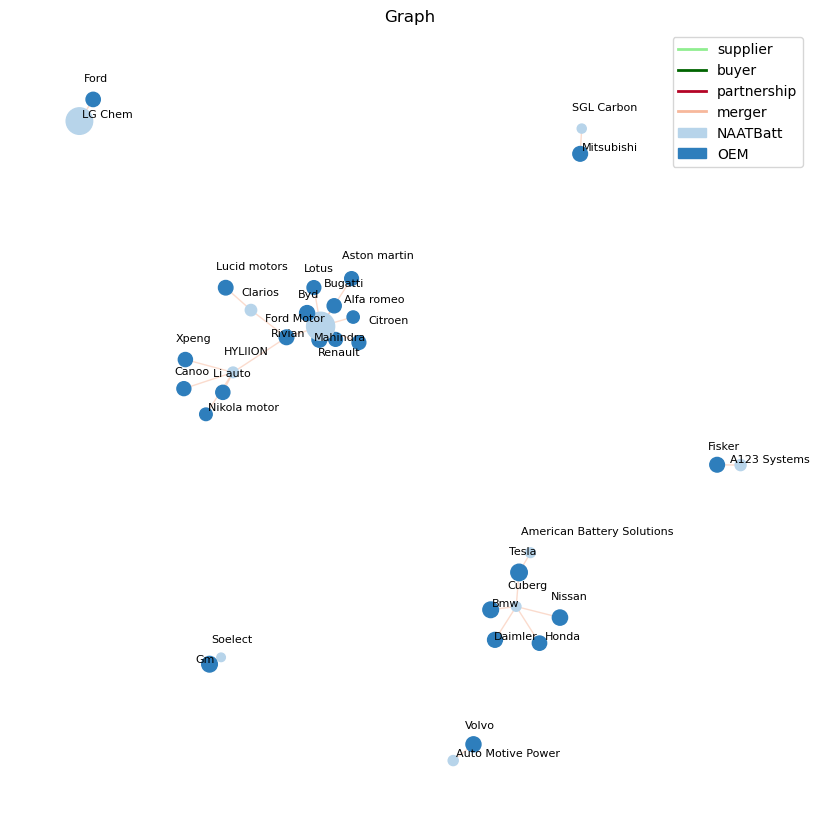

In [41]:
most_informative_plot(H, figsize = 8, scaling_factor = 1000, small = True).show()

#### Graph based on buyer

In [42]:

#filtering edges for supplier buyer relationships
filtered_edges = [(u, v) for u, v, attrs in G.edges(data=True) if attrs['relationship'] in ['buyer']]


In [43]:
#create subgraph
H = G.edge_subgraph(filtered_edges)


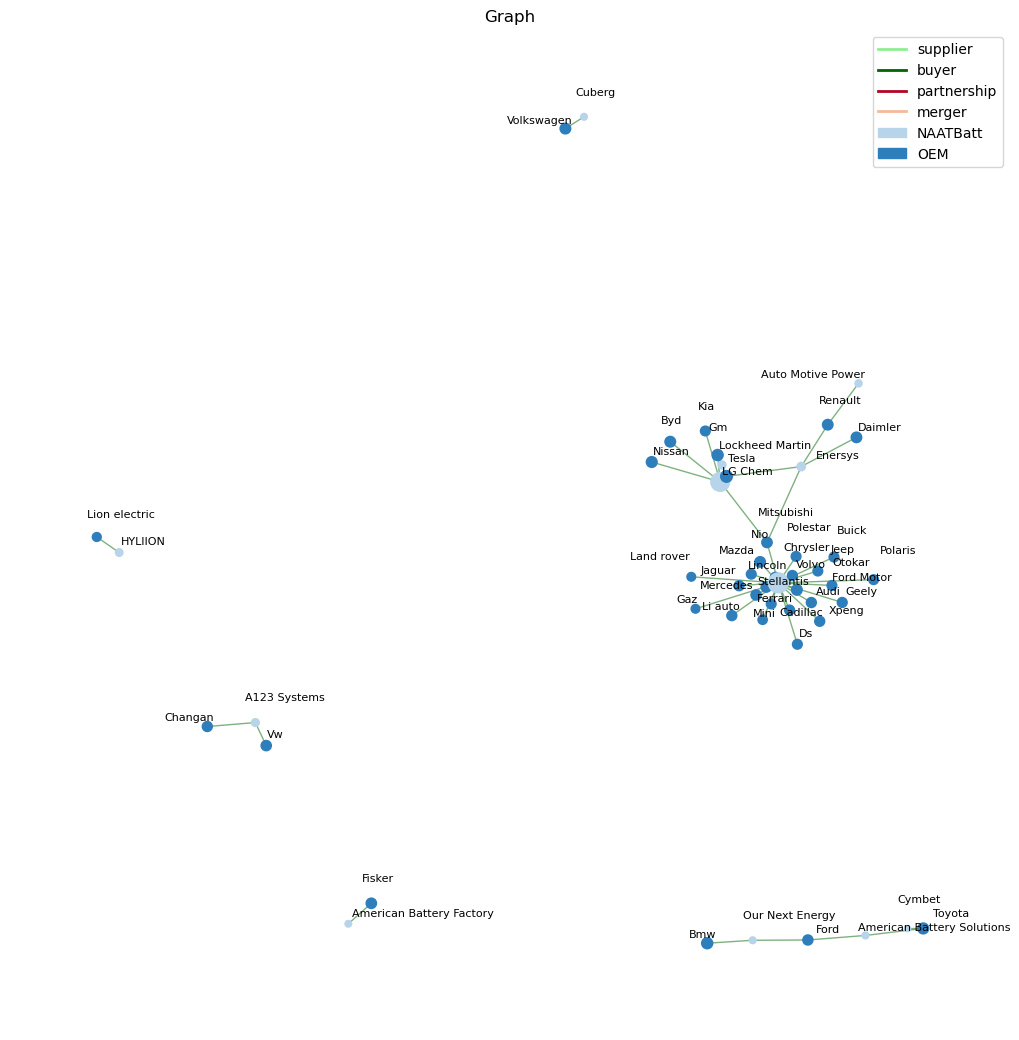

In [44]:
most_informative_plot(H, figsize = 10, scaling_factor = 500, small = True).show()

#### Graphs of Louvain Communities

In [45]:
#obtaining communities
communities_dict = community_louvain.best_partition(G)

#create subgraphs for each community
communities = {}
for node, community in communities_dict.items():
    if community not in communities:
        communities[community] = []
    communities[community].append(node)

#create subgraphs
subgraphs = []
for nodes in communities.values():
    subgraph = G.subgraph(nodes).copy()
    subgraphs.append(subgraph)

# Displaying the number of communities and nodes in each community
print(f"Number of communities: {len(subgraphs)}")
for i, sg in enumerate(subgraphs):
    print(f"Community {i} has {len(sg.nodes())} nodes")

Number of communities: 4
Community 0 has 37 nodes
Community 1 has 46 nodes
Community 2 has 31 nodes
Community 3 has 2 nodes


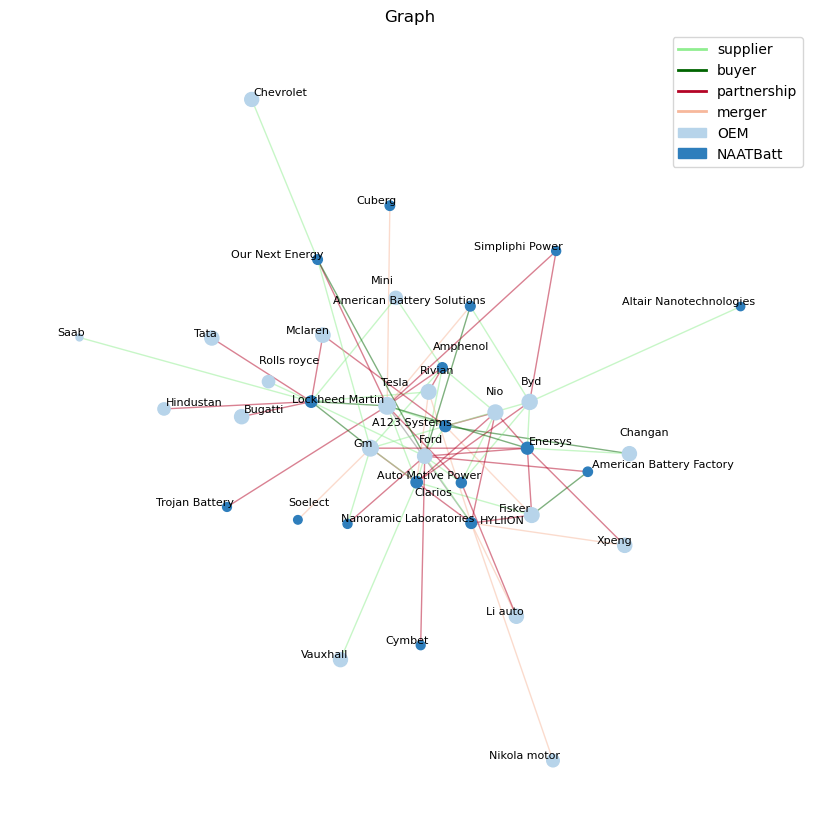

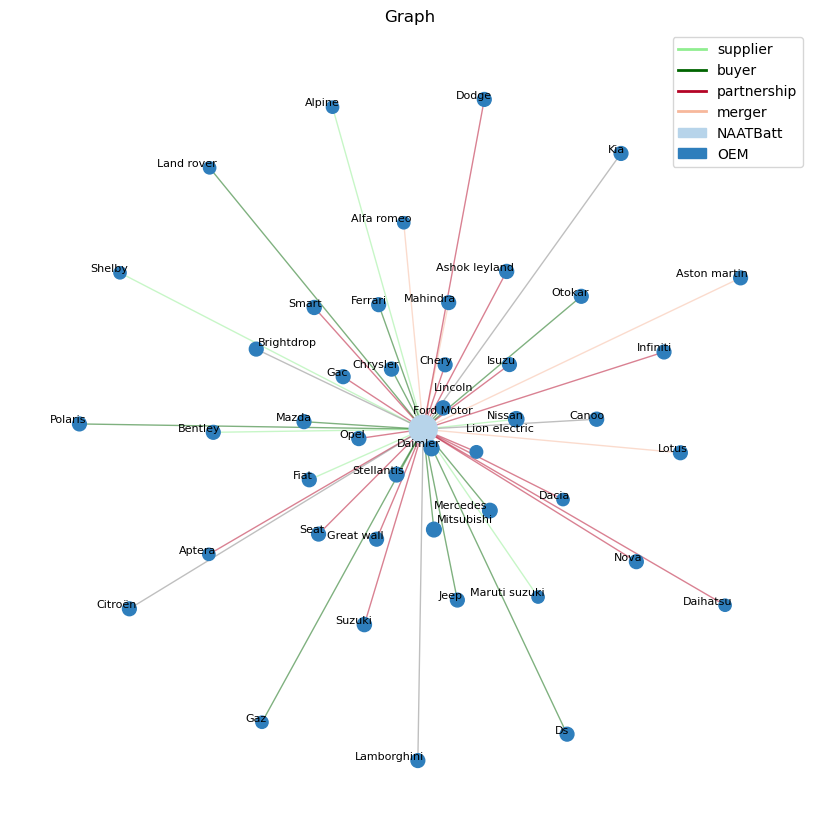

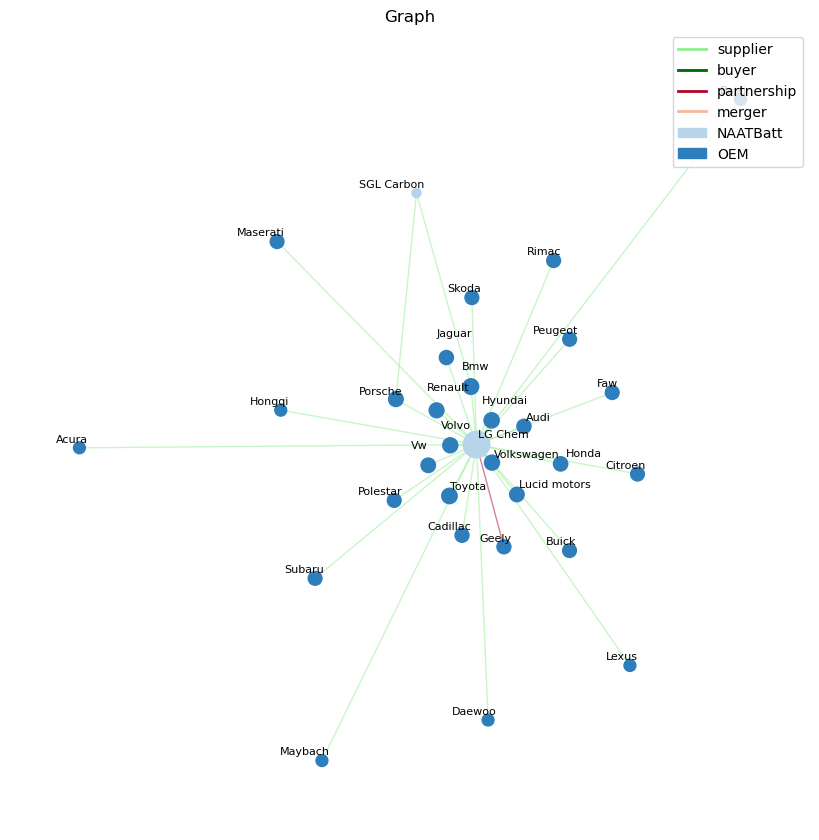

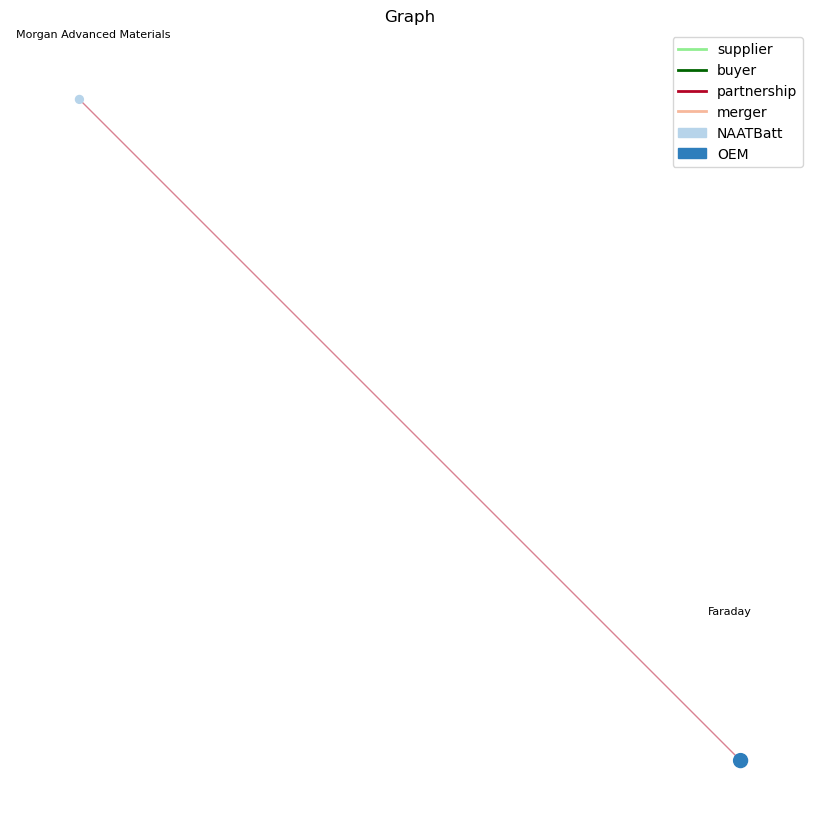

In [46]:
for i, sg in enumerate(subgraphs):
    most_informative_plot(sg, figsize = 8).show()